In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0')  # используй первую GPU (номеруются с нуля)

In [0]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2019-10-04 21:17:43--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  5.68MB/s    in 15s     

2019-10-04 21:17:59 (4.45 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [0]:
from tqdm import tqdm
from time import sleep

import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

      
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])


def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?
    

dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 743.30it/s]


In [0]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
#         nn.Dropout(0.1),
        nn.ReLU(),
#         nn.Upsample(scale_factor=2)
    )

class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
              nn.Conv2d(1, 32, (3, 3), padding=1), # по дефолту stride = 1, а следовательно размерность не меняется
              nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
              nn.ReLU(),
              nn.Upsample(scale_factor=2), 

              nn.Conv2d(32, 256, (3, 3), padding=1), 
              nn.MaxPool2d((2, 2), stride=(2, 2)),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),

              nn.Conv2d(256, 256, (3, 3), padding=1), 
              nn.MaxPool2d((2, 2), stride=(2, 2)),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),

              nn.Conv2d(256, 128, (3, 3), padding=1),
              nn.MaxPool2d((2, 2), stride=(2, 2)),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),  
            

              nn.Conv2d(128, 64, (3, 3), padding=1), 
              nn.MaxPool2d((2, 2), stride=(2, 2)),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),
      
#             nn.Conv2d(1, 32, (3, 3), padding=1), # по дефолту stride = 1, а следовательно размерность не меняется
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2), 
            
#             nn.Conv2d(32, 256, (3, 3), padding=1), 
#             nn.MaxPool2d((2, 2), stride=(2, 2)),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
            
#             nn.Conv2d(256, 256, (3, 3), padding=1), 
#             nn.MaxPool2d((2, 2), stride=(2, 2)),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
            
#             nn.Conv2d(256, 64, (3, 3), padding=1),
#             nn.MaxPool2d((2, 2), stride=(2, 2)),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),        
      
            
        )
         
        self.postconcat = nn.Sequential(        
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [0]:
num_epochs = 700
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = nn.L1Loss()  # тут можно поиграться с лоссами
criterion = nn.MSELoss()

history = []
for epoch in range(num_epochs):
    train_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        x_train = x.to(device)
        y_train = y.to(device)
        reconstructed = model(x_train).to(device)
        loss = criterion(y_train, reconstructed)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)
    print('epoch %d, loss %.4f' % (epoch, train_loss/len(loader)))

epoch 0, loss 0.0503
epoch 1, loss 0.0186
epoch 2, loss 0.0127
epoch 3, loss 0.0112
epoch 4, loss 0.0114
epoch 5, loss 0.0106
epoch 6, loss 0.0093
epoch 7, loss 0.0083
epoch 8, loss 0.0078
epoch 9, loss 0.0076
epoch 10, loss 0.0075
epoch 11, loss 0.0072
epoch 12, loss 0.0072
epoch 13, loss 0.0071
epoch 14, loss 0.0070
epoch 15, loss 0.0069
epoch 16, loss 0.0068
epoch 17, loss 0.0068
epoch 18, loss 0.0066
epoch 19, loss 0.0067
epoch 20, loss 0.0065
epoch 21, loss 0.0068
epoch 22, loss 0.0065
epoch 23, loss 0.0067
epoch 24, loss 0.0065
epoch 25, loss 0.0067
epoch 26, loss 0.0065
epoch 27, loss 0.0065
epoch 28, loss 0.0063
epoch 29, loss 0.0065
epoch 30, loss 0.0064
epoch 31, loss 0.0063
epoch 32, loss 0.0065
epoch 33, loss 0.0065
epoch 34, loss 0.0065
epoch 35, loss 0.0065
epoch 36, loss 0.0064
epoch 37, loss 0.0063
epoch 38, loss 0.0063
epoch 39, loss 0.0070
epoch 40, loss 0.0065
epoch 41, loss 0.0062
epoch 42, loss 0.0061
epoch 43, loss 0.0063
epoch 44, loss 0.0065
epoch 45, loss 0.006

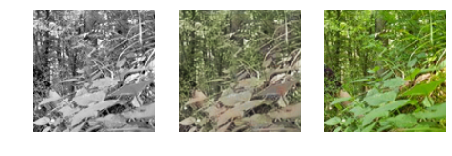

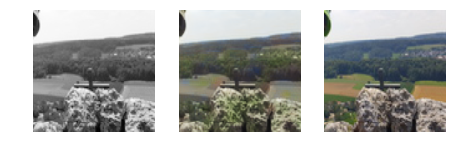

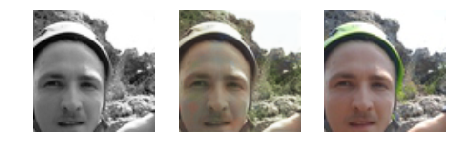

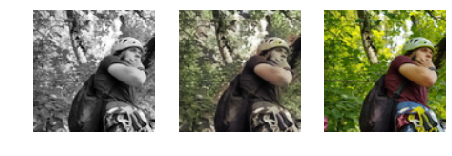

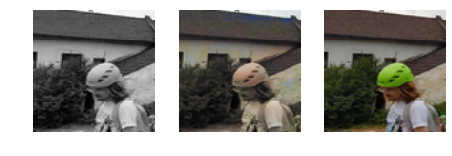

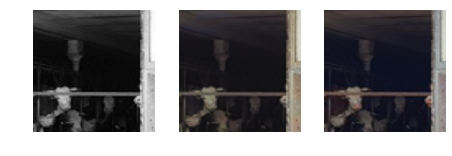

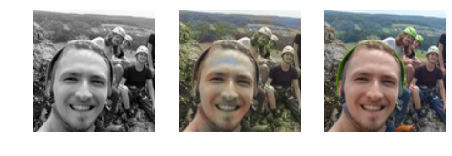

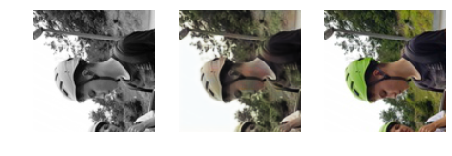

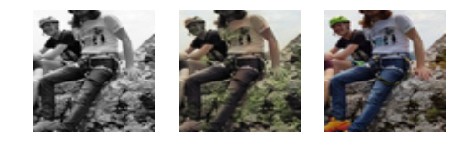

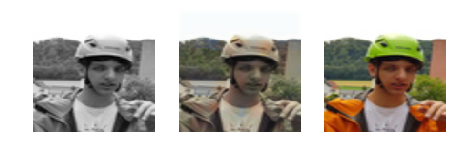

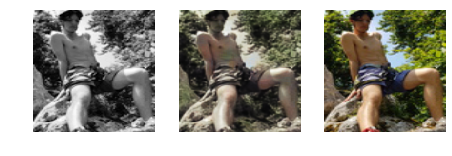

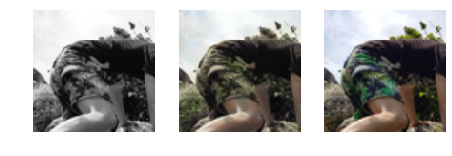

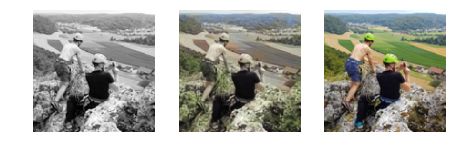

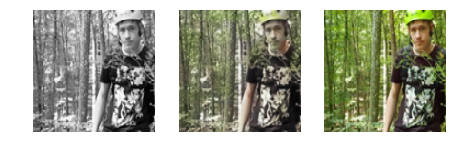

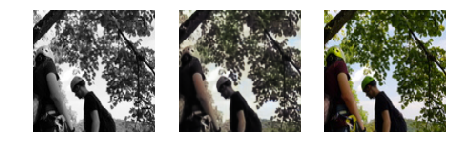

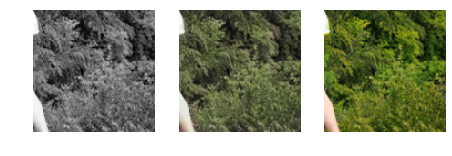

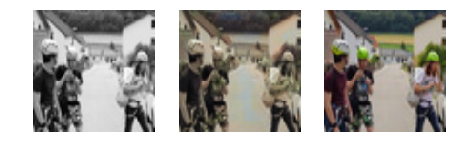

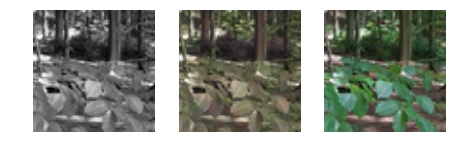

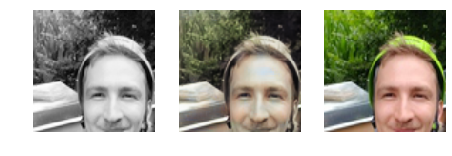

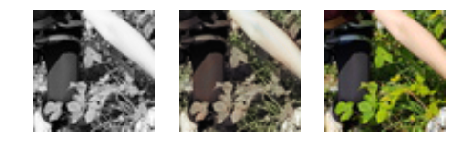

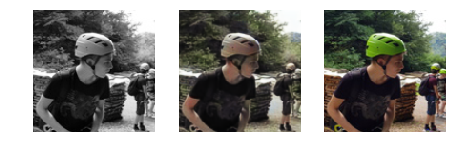

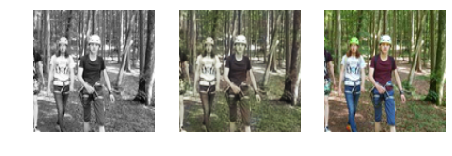

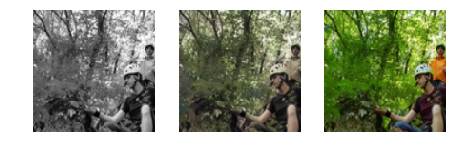

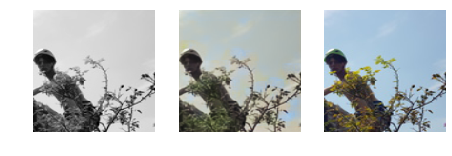

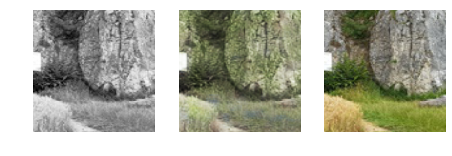

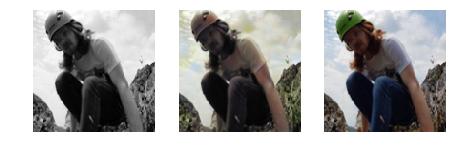

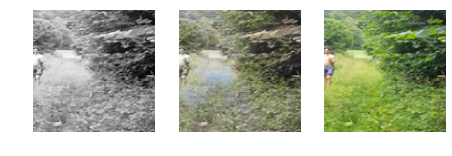

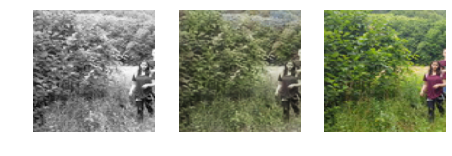

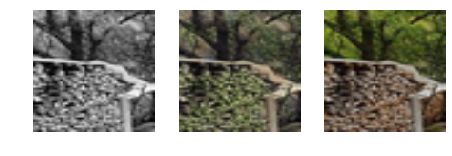

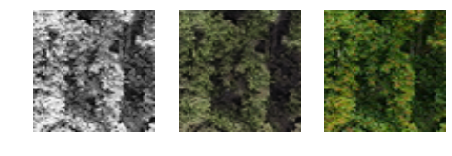

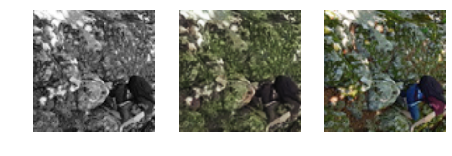

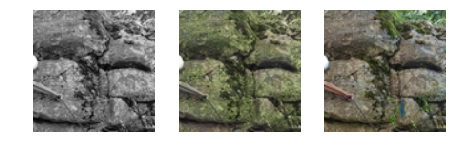

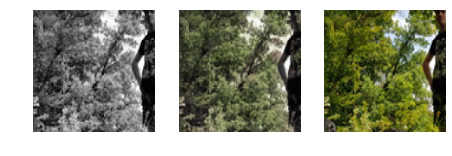

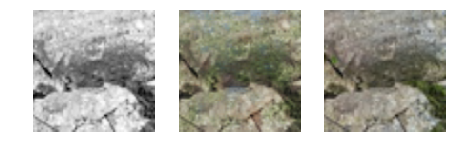

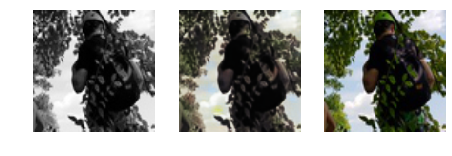

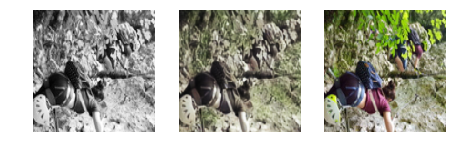

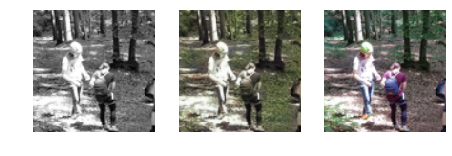

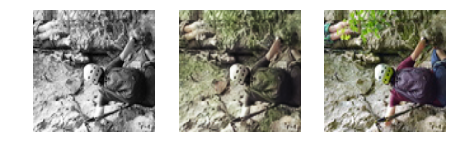

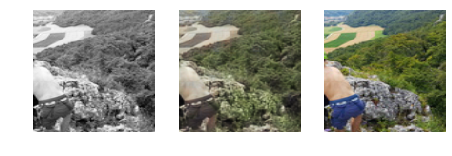

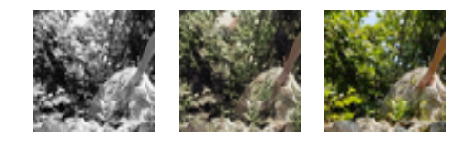

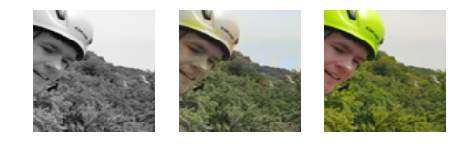

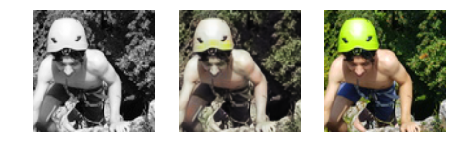

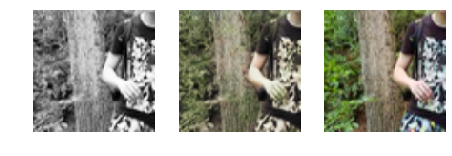

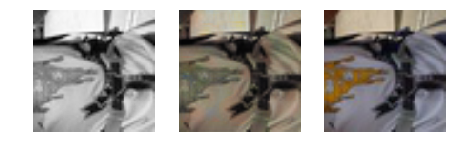

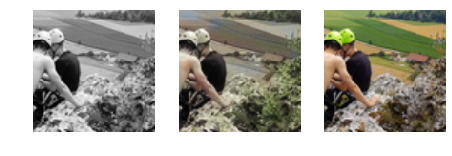

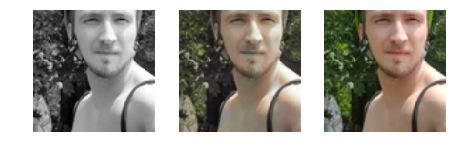

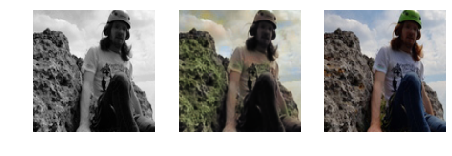

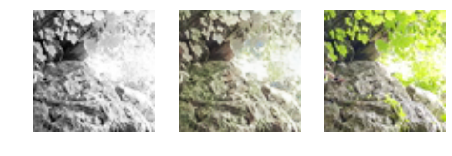

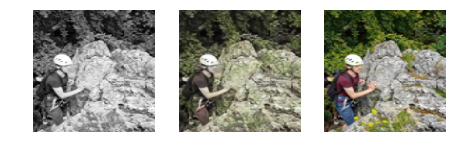

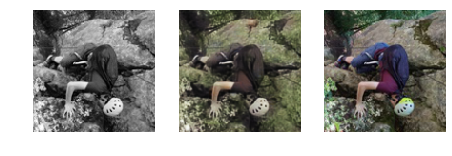

In [0]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

for i in range(100,150):
    img_gray, img_true = dataset[i]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))

    plt.figure(figsize=(10,10))

    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_pred).reshape((128, 128, 3)))

    plt.subplot(143)  
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))

    plt.show()